In [1]:
from tensorflow.keras.datasets import cifar10
import numpy as np
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.applications.vgg19 import VGG19, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import cv2
from keras_preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import categorical_crossentropy
from progressbar import ProgressBar
import os
import tensorflow as tf
import json

# from tensorflow.keras import backend as BE
# from Integrated_Gradients_algorithm import *
# from GradVisualizer import *

os.environ["CUDA_VISIBLE_DEVICES"] = "6"
config=tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess=tf.compat.v1.Session(config=config) 

In [348]:
def get_acc(predict_label, ground_truth=None):
    for i in predict_label[0]:
        if i[0] == ground_truth:
            return True
    return False

def softmax( f ):
    # instead: first shift the values of f so that the highest number is 0:
    f -= np.max(f) # f becomes [-666, -333, 0]
    return np.exp(f) / np.sum(np.exp(f))  # safe to do, gives the correct answer


# def get_APFD_ImageNet(Gini, WNID, predicted_confidence, top_set=None):
#     Gini = np.array(Gini)
#     indexs = np.argsort(Gini)[::-1]

#     o_i = 0
#     pbar = ProgressBar()
#     wrong_num = 0
#     for i in pbar(range(0, len(Gini))):
#         if top_set is not None:
#             if not get_acc(predict_label=decode_predictions(predicted_confidence[indexs[i]], top=top_set), ground_truth=WNID[val_ground_truth[indexs[i]]-1]):
#                 o_i = o_i+i
#                 print(i, o_i)
#                 wrong_num = wrong_num+1

#     APFD = 1 - o_i/(len(Gini)*wrong_num) + 1/(2*len(Gini))
#     print(o_i, len(Gini),wrong_num)
#     return APFD


def get_APFD(Gini_indexs, ground_truth_label, predicted_confidence, top_set=None):
    o_i = 0
    pbar = ProgressBar()
    wrong_num = 0
    wrong_num_index = []
    for i in pbar(range(0, len(Gini_indexs))):
        if top_set is not None:
            if not get_acc(predict_label=decode_predictions(predicted_confidence[Gini_indexs[i]], top=top_set), 
                           ground_truth=ground_truth_label[Gini_indexs[i]]):
                o_i = o_i+i
#                 print(i, o_i)
                wrong_num = wrong_num+1
                wrong_num_index.append(Gini_indexs[i])
        else:
            if np.argmax(ground_truth_label[Gini_indexs[i]]) != np.argmax(predicted_confidence[Gini_indexs[i]]):
                o_i = o_i+i
                wrong_num = wrong_num+1
                wrong_num_index.append(Gini_indexs[i])
    APFD = 1 - o_i/(len(Gini_indexs)*wrong_num) + 1/(2*len(Gini_indexs))
    return APFD, wrong_num, np.array(wrong_num_index).reshape(-1)


def get_RAUC(Gini_indexs, ground_truth_label, predicted_confidence, top_set=None):
    pre_y_axis = []
    o_i = 0
    wrong_num = 0
    pbar = ProgressBar()
    for i in pbar(range(0, len(Gini_indexs))):
        if top_set is not None:
            if not get_acc(predict_label=decode_predictions(predicted_confidence[Gini_indexs[i]], top=top_set), 
                           ground_truth=ground_truth_label[Gini_indexs[i]]):  
                o_i = o_i+1
                wrong_num = wrong_num+1
                pre_y_axis.append(o_i)
            else:
                pre_y_axis.append(o_i)
        else:
            if np.argmax(ground_truth_label[Gini_indexs[i]]) != np.argmax(predicted_confidence[Gini_indexs[i]]):
                o_i = o_i+1
                wrong_num = wrong_num+1
                pre_y_axis.append(o_i)
            else:
                pre_y_axis.append(o_i)
    true_y_axis = wrong_num*(len(Gini_indexs)-wrong_num) + (wrong_num+1)*wrong_num/2
    RAUC = np.sum(pre_y_axis)/true_y_axis
#     print("RAUC: ", RAUC)
    return RAUC, len(Gini_indexs), wrong_num

In [56]:
def get_img_array(img_path, size=(299, 299)):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def get_gradients(img_input, model, top_pred_idx):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        img_input: 4D image tensor
        top_pred_idx: Predicted label for the input image

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    images = tf.cast(img_input, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        top_class = preds[:, top_pred_idx]

    grads = tape.gradient(top_class, images)
    return grads


def get_integrated_gradients(img_input, model, top_pred_idx, baseline=None, num_steps=50):
    """Computes Integrated Gradients for a predicted label.

    Args:
        img_input (ndarray): Original image
        top_pred_idx: Predicted label for the input image
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with a black image
    # having same size as the input image.
    if baseline is None:
        baseline = np.zeros(img_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    img_input = img_input.astype(np.float32)
    interpolated_image = [
        baseline + (step / num_steps) * (img_input - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_image = np.array(interpolated_image).astype(np.float32)

    # 2. Preprocess the interpolated images
#     interpolated_image = model.preprocess_input(interpolated_image)

    # 3. Get the gradients
    grads = []
    for i, img in enumerate(interpolated_image):
        img = tf.expand_dims(img, axis=0)
        grad = get_gradients(img, model, top_pred_idx=top_pred_idx)
        grads.append(grad[0])
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads_tmp = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads_tmp, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (img_input - baseline) * avg_grads
    return integrated_grads, grads, avg_grads


def random_baseline_integrated_gradients(
    img_input, model, top_pred_idx, num_steps=50, num_runs=2
):
    """Generates a number of random baseline images.

    Args:
        img_input (ndarray): 3D image
        top_pred_idx: Predicted label for the input image
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    integrated_grads = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.random.random(img_size) * 255
        igrads, grads, avg_grads = get_integrated_gradients(
            img_input=img_input,
            top_pred_idx=top_pred_idx,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)

    # 3. Return the average integrated gradients for the image
    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)

In [3]:
def getfile_name(file_dir):   
    for root, dirs, files in os.walk(file_dir):
        return files
#          print(root) #当前目录路径  
#          print(dirs) #当前路径下所有子目录  
#          print(files) #当前路径下所有非目录子文件 


In [4]:
DATA_PATH = '/public/liujiawei/huawei/ZHB/ADF-master/datasets/ImageNetVal/'
file_name = getfile_name(DATA_PATH)
file_name = np.sort(file_name)

f = open("/public/liujiawei/huawei/ZHB/ADF-master/datasets/ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt",encoding = "utf-8")
val_ground_truth = f.read()
val_ground_truth = val_ground_truth.split('\n')
for i in range(len(val_ground_truth)-1):
    val_ground_truth[i] = int(val_ground_truth[i])

    
vgg19_json = json.load(open('/public/liujiawei/.keras/models/imagenet_class_index.json','r',encoding="utf-8"))
# numbers = []
# with open('/public/liujiawei/huawei/ZHB/ADF-master/datasets/ILSVRC2012_devkit_t12/data/ILSVRC2012_validation_ground_truth.txt', 'r') as f:
#     for line in f:
#         numbers.extend([int(num)
#                        for num in line.split('\n')])

In [5]:
print((file_name[0]))
label_tmp = file_name[0][-13:-5]
# label_tmp = int(label_tmp)+1.0
print((label_tmp=='00013979'))
print(np.shape(file_name))
print(np.sort(file_name)[999:1008])

ILSVRC2012_val_00000001.JPEG
False
(50000,)
['ILSVRC2012_val_00001000.JPEG' 'ILSVRC2012_val_00001001.JPEG'
 'ILSVRC2012_val_00001002.JPEG' 'ILSVRC2012_val_00001003.JPEG'
 'ILSVRC2012_val_00001004.JPEG' 'ILSVRC2012_val_00001005.JPEG'
 'ILSVRC2012_val_00001006.JPEG' 'ILSVRC2012_val_00001007.JPEG'
 'ILSVRC2012_val_00001008.JPEG']


In [6]:
# from gpuinfo import GPUInfo

# def get_gpu_id(num_gpu=1):
#     """get ID of GPUS
#     :param num_gpu:  num of GPUs to use
#     :return: gpu_id: ID of allocated GPUs
#     """
#     available_device=GPUInfo.check_empty()
#     if len(available_device)>=num_gpu:
#         gpu_id = available_device[:num_gpu]
#     else:
#         raise Exception('Only {} GPUs to use!'.format(len(available_device)))
#     if num_gpu == 1:
#         gpu_id = gpu_id[0]


#     return gpu_id

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# config=tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
# sess=tf.compat.v1.Session(config=config) 

In [7]:
base_model = VGG19(weights='imagenet')

In [8]:
import os
import scipy.io

synsets = scipy.io.loadmat(os.path.join('/public/liujiawei/huawei/ZHB/ADF-master/datasets', 'ILSVRC2012_devkit_t12', 'data', 'meta.mat'))['synsets']
# print(len(synsets))
# print(synsets)

ILSVRC2012_ID = [s[0][0][0][0] for s in synsets]
# print(ILSVRC2012_ID)

index1 = 821
WNID = [s[0][1][0] for s in synsets]
print(WNID[index1])

words = [s[0][2][0] for s in synsets]
print(words[index1])

num_train_images = [s[0][7][0][0] for s in synsets]
print(num_train_images[0])

n04263257
soup bowl
1300


In [9]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [13]:
# img_num = range(0,1000) # 设置使用的样本数量和位置
# pbar = ProgressBar()
# acc = 0
# for i in pbar(img_num):
# #     print(file_name[i])
#     img_path = DATA_PATH + file_name[i]
#     img = image.load_img(img_path, target_size=(224, 224))
#     x_tmp = image.img_to_array(img)
#     x_tmp = np.expand_dims(x_tmp, axis=0)
#     x_tmp = preprocess_input(x_tmp)
#     y_tmp = base_model.predict(np.reshape(x_tmp, [-1,224,224,3]))
# #     print(WNID[val_ground_truth[i]])
# # *********************注意这里的 WNID 的索引需要“-1”*************************
#     acc = acc + get_acc(predict_label=decode_predictions(y_tmp, top=1), ground_truth=WNID[val_ground_truth[i]-1])
# #     if decode_predictions(y_tmp, top=3)[0][0][0] == WNID[val_ground_truth[i]]:
# #         acc = acc+1
    
# print("The number of right classified:", acc)

In [14]:
# img_num = range(0,10)
# pbar = ProgressBar()
# for i in pbar(img_num):
#     print(WNID[val_ground_truth[i]])

In [11]:
# print(decode_predictions(y_tmp, top=4)[0][3][0])  ## 第一维的[0]是固定的，第二维的[i]表示第top(i+1)，第三维的[0]表示标签、[1]表示标签的真实名字、[2]表示标签的对应置信度
# print(decode_predictions(y_tmp, top=4)[0][3][1])
# print(decode_predictions(y_tmp, top=4)[0][3][2])

In [10]:
WNID[val_ground_truth[i]-1]

'n02437616'

In [11]:
# get_acc(predict_label=decode_predictions(y_tmp, top=3), ground_truth=WNID[val_ground_truth[i]])

In [12]:
# pbar = ProgressBar()
# tmp_train = [cv2.resize(i,(224,224)) for i in pbar(X_train)]
# pbar = ProgressBar()
# tmp_test = [cv2.resize(i,(224,224)) for i in pbar(X_test)]
# ## 重新转回为 array
# # tmp_train = np.array(tmp_train)
# # tmp_test = np.array(tmp_test)

# print(len(tmp_train))
# print(np.shape(tmp_train[0:2]))

In [13]:
# # keras 的图像处理操作
# img_path = 'zebra.png'
# img = image.load_img(img_path, target_size=(224, 224))
# x = image.img_to_array(img)
# x = np.expand_dims(x, axis=0)
# x = preprocess_input(x)
# y1 = base_model.predict(np.reshape(img, [-1,224,224,3]))
# print(np.argmax(y1))

# # keras 预训练模型的标签解释器
# print('Predicted:', decode_predictions(y1, top=3))

In [14]:
# import matplotlib.pyplot as plt

# plt.figure()
# plt.subplot(111)
# plt.imshow(np.reshape(x, [224,224,3]))

In [477]:
Gini = []
index1 = 0
index2 = 0
top_set = 1 # 预测的前n个类中包含真实标签则表示预测正确
img_num = range(0, 1000)
num_class = 1000
ground_truth_label = []
predicted_confidence = []
# advrage_confidence = np.ones((1,num_class))*(1.0/(num_class-1))
# advrage_confidence = np.zeros((1,num_class))
pbar = ProgressBar()
for i in pbar(img_num):
    img_path = DATA_PATH + file_name[i]
    img = image.load_img(img_path, target_size=(224, 224))
    x_tmp = image.img_to_array(img)
    x_tmp = np.expand_dims(x_tmp, axis=0)
    x_tmp = preprocess_input(x_tmp)
    pre_tmp = base_model.predict(np.reshape(x_tmp, [-1,224,224,3]))
    
    Gini_tmp = 1-np.sum(pre_tmp*pre_tmp)  # 基于基尼指数
#     Gini_tmp = -np.sum(pre_tmp*np.log(pre_tmp))  # 基于信息熵
#     advrage_confidence[0][np.argmax(pre_tmp)] = 1
#     Gini_tmp = -np.sum(advrage_confidence*np.log(pre_tmp))  # 基于交叉熵/反交叉熵
    Gini.append(Gini_tmp)
    
#     index2 = index2 + get_acc(predict_label=decode_predictions(pre_tmp, top=top_set), ground_truth=WNID[val_ground_truth[i]-1])
#     index1 = index1 + 1
    predicted_confidence.append(pre_tmp)
    ground_truth_label.append(WNID[val_ground_truth[i]-1])

100% |########################################################################|


In [478]:
# print('test number:', index1, '\t misclassified number:', index1-index2)

In [479]:
indexs = np.argsort(Gini)
indexs = indexs[::-1]
# # 计算APFD指标
APFD,_,_ = get_APFD(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), predicted_confidence=np.array(predicted_confidence), top_set=top_set)
print("APFD: ", APFD)
# o_i = 0
# pbar = ProgressBar()
# # for i in pbar(range(0, (index1-index2))):
# for i in (range(0, index1)):
#     img_path = DATA_PATH + file_name[indexs[i]]
#     img = image.load_img(img_path, target_size=(224, 224))
#     x_tmp = image.img_to_array(img)
#     x_tmp = np.expand_dims(x_tmp, axis=0)
#     x_tmp = preprocess_input(x_tmp)
#     pre_tmp = base_model.predict(np.reshape(x_tmp, [-1,224,224,3]))
#     if not get_acc(predict_label=decode_predictions(pre_tmp, top=top_set), ground_truth=WNID[val_ground_truth[indexs[i]]-1]):
#         o_i = o_i+i
#         print(i, o_i)
# APFD = 1-o_i/(index1*(index1-index2))+1/(2*index1)
# print("APFD: ", APFD, o_i, index1, index1-index2)

APFD:  0.7350498575498575


In [13]:
# 前200个样本
APFD:  0.901875  #基于基尼指数
APFD:  0.8989062499999999    # 基于信息熵
    
# 前10000个样本
APFD:  0.8936016026566561   #基于基尼指数

In [480]:
# 计算RAUC指标
RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), 
                predicted_confidence=np.array(predicted_confidence), top_set=top_set)
print("RAUC: ", RAUC)
# true_y_axis = []
# pre_y_axis = []
# o_i = 0
# pbar = ProgressBar()
# for i in pbar(range(0, index1)):
#     img_path = DATA_PATH + file_name[indexs[i]]
#     img = image.load_img(img_path, target_size=(224, 224))
#     x_tmp = image.img_to_array(img)
#     x_tmp = np.expand_dims(x_tmp, axis=0)
#     x_tmp = preprocess_input(x_tmp)
#     pre_tmp = base_model.predict(np.reshape(x_tmp, [-1,224,224,3]))
#     if not get_acc(predict_label=decode_predictions(pre_tmp, top=top_set), ground_truth=WNID[val_ground_truth[indexs[i]]-1]):
#         o_i = o_i+1
#         pre_y_axis.append(o_i)
#     else:
#         pre_y_axis.append(o_i)
#     if i < index1-index2:
#         true_y_axis.append(i+1)
#     else:
#         true_y_axis.append(index1-index2)
            
# RAUC = np.sum(pre_y_axis)/np.sum(true_y_axis)
# print("RAUC: ", RAUC)

RAUC:  0.890363463696797


In [57]:
# # 使用中间隐层特征计算基尼指数/信息熵
# from tensorflow.keras import backend as BE

# model = Model(inputs=base_model.input, outputs=base_model.get_layer('predictions').output)
# Gini_act=[]
# pbar = ProgressBar()
# for i in pbar(img_num):
#     img_path = DATA_PATH + file_name[i]
#     img = image.load_img(img_path, target_size=(224, 224))
#     x_tmp = image.img_to_array(img)
#     x_tmp = np.expand_dims(x_tmp, axis=0)
#     x_tmp = preprocess_input(x_tmp)
    
# #     # 使用attention机制
# #     x_act = model.predict(x_tmp.reshape([-1,224,224,3]))
# #     att1 = np.dot(np.transpose(x_act), x_act)
# #     att_weight = np.mean(att1, axis = 0).reshape(np.shape(x_act))
# #     x_act_ = softmax(x_act)*softmax(att_weight)
# # #     Gini_tmp = 1-np.sum(x_act_*x_act_)  # 基于基尼指数
# #     Gini_tmp = 1-np.sum(x_act_*np.log(x_act_))  # 基于信息熵
# #     Gini_act.append(Gini_tmp)
    
#     #  未使用attention机制
#     x_act = softmax(model.predict(np.reshape(x_tmp, [-1,224,224,3])))
#     Gini_tmp = 1-np.sum(x_act*x_act)  # 基于基尼指数
# #     Gini_tmp = 1-np.sum(x_act*np.log(x_act))  # 基于信息熵
#     Gini_act.append(Gini_tmp)


100% |########################################################################|


In [290]:
# # 使用梯度信息
# Gini_act = []
# num_class = 1000
# img_size = (224,224,3)
# # img_num = range(0,250)
# pbar = ProgressBar()

# for i in pbar(img_num):
    
#     img_path = DATA_PATH + file_name[i]
#     img = image.load_img(img_path, target_size=(224, 224))
#     x_tmp = image.img_to_array(img)
#     x_tmp = np.expand_dims(x_tmp, axis=0)
#     x_tmp = preprocess_input(x_tmp)
#     preds = base_model.predict(x_tmp)
    
# #     使用真实标签验证
# #     for j1 in range(1000):
# #         if vgg19_json[str(j1)][0] == WNID[val_ground_truth[i]-1]:
# #             break
# #     grads = get_loss_gradients(img_input=x_tmp, model=base_model, 
# #                                target_one_hot=np.reshape(to_categorical(j1, 1000),(-1,1000)))
    
# #     使用预测标签当做真实标签验证
#     model_ = Model(inputs=model.input, outputs=base_model.get_layer('fc2').output)
#     hidden_layer = model_.predict(x_tmp)
#     dim1 = len(hidden_layer[0])
#     target_one_hot_ave = np.zeros([1, dim1]) * (1.0/dim1)
#     target_one_hot_ave[0][np.argmax(hidden_layer[0])] = 1
#     target_one_hot_ave = target_one_hot_ave * hidden_layer
#     grads = get_loss_gradients(img_input=x_tmp, model=model_, 
#                                target_one_hot=target_one_hot_ave, from_logits=False)
    
# #     label1 = np.argmax(preds[0])
# #     target_one_hot = np.reshape(to_categorical(label1, num_class), (-1, num_class))
# #     grads = get_loss_gradients(img_input=x_tmp, model=base_model, 
# #                                target_one_hot=target_one_hot)

# #     grads = np.clip(grads, 0, 1)
# #     preds[0][label1] = -1
# #     label2 = np.argmax(preds[0])
# #     grads2 = get_loss_gradients(img_input=x_tmp, model=base_model, 
# #                                target_one_hot=target_one_hot)

#     x_act = np.sum(np.abs(grads))
# #     if np.sum(np.abs(grads))>np.sum(np.abs(grads2)):
# #         x_act = 1
# #     else:
# #         x_act=2
        
# #     grads = get_gradients(img_input=x_tmp, model=base_model, top_pred_idx=tf.argmax(preds[0]))
# #     preds[0][tf.argmax(preds[0])] = -1
# #     grads2 = get_gradients(img_input=x_tmp, model=base_model, top_pred_idx=tf.argmax(preds[0]))
# #     if np.sum(np.abs(grads))>np.sum(np.abs(grads2)):
# #         x_act = 1
# #     else:
# #         x_act=2
    
# #     grads = np.clip(grads, -1, 0)
# #     grads2 = np.clip(grads2, -1, 0)
# #     x_act = np.sum(np.abs(grads)) - np.sum(np.abs(grads2))
# #     grads_min = get_gradients(img_input=x_tmp, model=base_model, top_pred_idx=tf.argmin(preds[0]))
# #     x_act = np.sum(np.abs(grads)) * np.sum(np.abs(grads_min))



# #     preds = base_model.predict(x_tmp)
# # #     grads = get_gradients(img_input=x_tmp, model=base_model, top_pred_idx=tf.argmax(preds[0]))
# #     integrated_grads, grads, avg_grads = get_integrated_gradients(img_input=x_tmp[0], model=base_model, top_pred_idx=tf.argmax(preds[0]), num_steps=2)
# #     x_act = np.sum(np.abs(grads[2]))+np.sum(np.abs(grads[0]))
# #     print(np.sum(np.abs(grads[2])),np.sum(np.abs(grads[1])),np.sum(np.abs(grads[0])),np.sum(np.abs(avg_grads)))
# # #     grads_min = get_gradients(img_input=x_tmp, model=base_model, top_pred_idx=tf.argmin(preds[0]))
# # #     x_act = np.sum(np.abs(grads)) * np.sum(np.abs(grads_min))
    
# #     pbar = ProgressBar()
# #     x_act = []
# #     for label_i in pbar(range(num_class)):
# #         grads = get_gradients(img_input=x_tmp, model=base_model, top_pred_idx=label_i)
# # #         grads = get_integrated_gradients(img_input=x_tmp, model=base_model, top_pred_idx=label_i)
# #         x_act.append(np.sum(grads))
# #     x_act = np.array(x_act).reshape(-1, num_class)
# #     x_act = softmax(x_act)
    
# #     Gini_tmp = 1-np.sum(x_act*x_act)   
#     Gini_act.append(x_act)

100% |########################################################################|


In [639]:
# 使用梯度信息
# img_num = range(0, 250)
# Gini_act = []
num_class = 1000
img_size = (224,224,3)
pbar = ProgressBar()

# grads_CE = []
# grads_RCE = []
# grads_pre1 = []
# grads_pre2 = []
# grads_pre_min = []
# grads_CE_ave = []
# grads_CE_min = []
# grads_CE2 = []

grads_CE_positive = []
grads_CE_negtive = []

for i in pbar(img_num):
    
    img_path = DATA_PATH + file_name[i]
    img = image.load_img(img_path, target_size=(224, 224))
    x_tmp = image.img_to_array(img)
    x_tmp = np.expand_dims(x_tmp, axis=0)
    x_tmp = preprocess_input(x_tmp)
    preds = base_model.predict(x_tmp)
    
#     使用预测标签当做真实标签验证
    label1 = np.argmax(preds[0])
    target_one_hot = preds
    target_one_hot[0][label1] = 1
    grads = get_loss_gradients(img_input=x_tmp, model=base_model, target_one_hot=target_one_hot)
    grads_CE_positive.append(grads)
    
    target_one_hot = preds
    target_one_hot[0][label1] = 0
    grads = get_loss_gradients(img_input=x_tmp, model=base_model, target_one_hot=target_one_hot)
    grads_CE_negtive.append(grads)

#     label1 = np.argmax(preds[0])
#     target_one_hot = np.reshape(to_categorical(label1, num_class), (-1, num_class))
#     grads = get_loss_gradients(img_input=x_tmp, model=base_model, target_one_hot=target_one_hot)
#     grads_CE.append(grads)
    
#     label1_min = np.argmin(preds[0])
#     target_one_hot = np.reshape(to_categorical(label1_min, num_class), (-1, num_class))
#     grads = get_loss_gradients(img_input=x_tmp, model=base_model, target_one_hot=target_one_hot)
#     grads_CE_min.append(grads)
    
#     grads = get_gradients(img_input=x_tmp, model=base_model, top_pred_idx=label1_min)
#     grads_pre_min.append(grads)
    
#     target_one_hot = np.ones([1, num_class]) * (1.0/(num_class-1))
#     target_one_hot[0][label1] = 0
#     grads = get_loss_gradients(img_input=x_tmp, model=base_model, target_one_hot=target_one_hot)
#     grads_RCE.append(grads)
    
#     target_one_hot = np.ones([1, num_class]) * (1.0/(num_class))
#     grads = get_loss_gradients(img_input=x_tmp, model=base_model, target_one_hot=target_one_hot)
#     grads_CE_ave.append(grads)
    
#     grads = get_gradients(img_input=x_tmp, model=base_model, top_pred_idx=label1)
#     grads_pre1.append(grads)
    
#     preds[0][label1] = 0
#     label2 = np.argmax(preds[0])
#     grads = get_gradients(img_input=x_tmp, model=base_model, top_pred_idx=label2)
#     grads_pre2.append(grads)
    
#     target_one_hot = np.reshape(to_categorical(label2, num_class), (-1, num_class))
#     grads = get_loss_gradients(img_input=x_tmp, model=base_model, target_one_hot=target_one_hot)
#     grads_CE2.append(grads)


100% |########################################################################|


In [645]:
Gini_act_ =[]
pbar = ProgressBar()
for i in pbar(range(len(grads_CE_positive))):
#     x_act = np.sum(np.abs(grads_CE[i]))
    x_act =[np.sum(np.abs(grads_CE_positive[i])),
            np.sum(np.abs(grads_CE_negtive[i])),
           ]
#     print(i,':',x_act)
    Gini_act_.append(x_act)
    
Gini_act_ = np.array(Gini_act_)
indexs = np.argsort(Gini_act_[:,1]/Gini_act_[:,0])
# print(indexs)
indexs = indexs[::-1]
# print(indexs)
APFD,wrong_number,wrong_index = get_APFD(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), 
                predicted_confidence=np.array(predicted_confidence), top_set=top_set)
print("APFD: ", APFD, wrong_number)
RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), 
                predicted_confidence=np.array(predicted_confidence), top_set=top_set)
print("RAUC: ", RAUC)

100% |########################################################################|
100% |########################################################################|


APFD:  0.6904088319088318 351
RAUC:  0.8362531295864629


In [341]:
for i in range(10):
    print(np.sum(np.abs(grads_CE[i])),np.sum(np.abs(grads_RCE[i])),np.sum(np.abs(grads_CE_ave[i])),
      np.sum(np.abs(grads_pre1[i])),np.sum(np.abs(grads_pre2[i])))
print('*******************************************************')
print(np.sum(np.abs(grads_CE)),np.sum(np.abs(grads_RCE)),np.sum(np.abs(grads_CE_ave)),
      np.sum(np.abs(grads_pre1)),np.sum(np.abs(grads_pre2)))

7.3869915 11.189025 11.174898 2.115178 2.8073308
2.4294407 17.323147 17.304945 1.8713104 1.8632013
2.875944 11.7236 11.711569 1.4050138 1.4200213
5.270518 11.276661 11.262339 2.0938423 1.1635923
2.7589445 22.305952 22.282848 1.2901204 1.3552691
3.7819545 8.438682 8.427843 1.1134738 0.5739374
0.6285847 19.955963 19.935661 0.5863522 0.4647086
7.466598 12.038355 12.022115 4.387728 2.2807024
8.709082 5.83937 5.829669 2.57412 1.7856172
3.950269 34.457554 34.420277 3.4191606 1.767835
*******************************************************
695.92035 3611.6404 3607.7095 294.23935 189.24251


In [491]:
print(np.shape(grads_CE),np.shape(grads_RCE),np.shape(grads_pre1),np.shape(grads_pre2),
      np.shape(grads_pre_min),np.shape(grads_CE_ave),np.shape(grads_CE_min),np.shape(grads_CE2))

(1000, 1, 224, 224, 3) (1000, 1, 224, 224, 3) (1000, 1, 224, 224, 3) (1000, 1, 224, 224, 3) (1000, 1, 224, 224, 3) (1000, 1, 224, 224, 3) (1000, 1, 224, 224, 3) (1000, 1, 224, 224, 3)


In [646]:
Gini_act =[]
pbar = ProgressBar()
for i in pbar(range(len(grads_CE))):
#     x_act = np.sum(np.abs(grads_CE[i]))
    x_act =[np.sum(np.abs(grads_CE[i])),
            np.sum(np.abs(grads_CE2[i])),
            np.sum(np.abs(grads_CE_min[i])),
            np.sum(np.abs(grads_RCE[i])),
            np.sum(np.abs(grads_CE_ave[i])),
            np.sum(np.abs(grads_pre1[i])),
            np.sum(np.abs(grads_pre2[i])),
            np.sum(np.abs(grads_pre_min[i])),
            np.std(grads_CE[i]),
            np.std(grads_CE2[i]),
            np.std(grads_CE_min[i]),
            np.std(grads_RCE[i]),
            np.std(grads_CE_ave[i]),
            np.std(grads_pre1[i]),
            np.std(grads_pre2[i]),
            np.std(grads_pre_min[i]),
           ]
#     print(i,':',x_act)
    Gini_act.append(x_act)
    
#     # attention 机制
# for i in pbar(range(len(grads_CE))):
# #     x_act = np.sum(np.abs(grads_CE[i]))
#     x_act =[np.sum(np.abs(  [np.dot( np.transpose(grads_CE[i], (0,3,1,2))[0][0] , np.transpose(grads_CE[i], (0,3,2,1))[0][0]),
#                              np.dot( np.transpose(grads_CE[i], (0,3,1,2))[0][1] , np.transpose(grads_CE[i], (0,3,2,1))[0][1]),
#                              np.dot( np.transpose(grads_CE[i], (0,3,1,2))[0][2] , np.transpose(grads_CE[i], (0,3,2,1))[0][2])]  )),
#             np.sum(np.abs(  [np.dot( np.transpose(grads_CE2[i], (0,3,1,2))[0][0] , np.transpose(grads_CE2[i], (0,3,2,1))[0][0]),
#                              np.dot( np.transpose(grads_CE2[i], (0,3,1,2))[0][1] , np.transpose(grads_CE2[i], (0,3,2,1))[0][1]),
#                              np.dot( np.transpose(grads_CE2[i], (0,3,1,2))[0][2] , np.transpose(grads_CE2[i], (0,3,2,1))[0][2])]  )),
#             np.sum(np.abs(  [np.dot( np.transpose(grads_CE_min[i], (0,3,1,2))[0][0] , np.transpose(grads_CE_min[i], (0,3,2,1))[0][0]),
#                              np.dot( np.transpose(grads_CE_min[i], (0,3,1,2))[0][1] , np.transpose(grads_CE_min[i], (0,3,2,1))[0][1]),
#                              np.dot( np.transpose(grads_CE_min[i], (0,3,1,2))[0][2] , np.transpose(grads_CE_min[i], (0,3,2,1))[0][2])]  )),
#             np.sum(np.abs(  [np.dot( np.transpose(grads_RCE[i], (0,3,1,2))[0][0] , np.transpose(grads_RCE[i], (0,3,2,1))[0][0]),
#                              np.dot( np.transpose(grads_RCE[i], (0,3,1,2))[0][1] , np.transpose(grads_RCE[i], (0,3,2,1))[0][1]),
#                              np.dot( np.transpose(grads_RCE[i], (0,3,1,2))[0][2] , np.transpose(grads_RCE[i], (0,3,2,1))[0][2])]  )),
#             np.sum(np.abs(  [np.dot( np.transpose(grads_CE_ave[i], (0,3,1,2))[0][0] , np.transpose(grads_CE_ave[i], (0,3,2,1))[0][0]),
#                              np.dot( np.transpose(grads_CE_ave[i], (0,3,1,2))[0][1] , np.transpose(grads_CE_ave[i], (0,3,2,1))[0][1]),
#                              np.dot( np.transpose(grads_CE_ave[i], (0,3,1,2))[0][2] , np.transpose(grads_CE_ave[i], (0,3,2,1))[0][2])]  )),
#             np.sum(np.abs(  [np.dot( np.transpose(grads_pre1[i], (0,3,1,2))[0][0] , np.transpose(grads_pre1[i], (0,3,2,1))[0][0]),
#                              np.dot( np.transpose(grads_pre1[i], (0,3,1,2))[0][1] , np.transpose(grads_pre1[i], (0,3,2,1))[0][1]),
#                              np.dot( np.transpose(grads_pre1[i], (0,3,1,2))[0][2] , np.transpose(grads_pre1[i], (0,3,2,1))[0][2])]  )),
#             np.sum(np.abs(  [np.dot( np.transpose(grads_pre2[i], (0,3,1,2))[0][0] , np.transpose(grads_pre2[i], (0,3,2,1))[0][0]),
#                              np.dot( np.transpose(grads_pre2[i], (0,3,1,2))[0][1] , np.transpose(grads_pre2[i], (0,3,2,1))[0][1]),
#                              np.dot( np.transpose(grads_pre2[i], (0,3,1,2))[0][2] , np.transpose(grads_pre2[i], (0,3,2,1))[0][2])]  )),
#             np.sum(np.abs(  [np.dot( np.transpose(grads_pre_min[i], (0,3,1,2))[0][0] , np.transpose(grads_pre_min[i], (0,3,2,1))[0][0]),
#                              np.dot( np.transpose(grads_pre_min[i], (0,3,1,2))[0][1] , np.transpose(grads_pre_min[i], (0,3,2,1))[0][1]),
#                              np.dot( np.transpose(grads_pre_min[i], (0,3,1,2))[0][2] , np.transpose(grads_pre_min[i], (0,3,2,1))[0][2])]  ))]
# #     print(i,':',x_act)
#     Gini_act.append(x_act)

100% |########################################################################|


In [647]:
Gini_act = np.array(Gini_act)
# indexs = np.argsort(np.sqrt(Gini_act[:,0]*Gini_act[:,0]+Gini_act[:,5]*Gini_act[:,5]+Gini_act[:,6]*Gini_act[:,6]+Gini_act[:,7]*Gini_act[:,7])/
#                     np.sqrt(Gini_act[:,1]*Gini_act[:,1]+Gini_act[:,2]*Gini_act[:,2]+Gini_act[:,3]*Gini_act[:,3]+Gini_act[:,4]*Gini_act[:,4]))
indexs = np.argsort(np.abs(Gini_act[:,0]/(np.abs(Gini_act[:,1]))))
#                     np.sqrt(Gini_act[:,1]+Gini_act[:,2]+Gini_act[:,3]+Gini_act[:,4]))
# print(indexs)
indexs = indexs[::-1]
# print(indexs)
APFD,wrong_number,wrong_index = get_APFD(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), 
                predicted_confidence=np.array(predicted_confidence), top_set=top_set)
print("APFD: ", APFD, wrong_number)
RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), 
                predicted_confidence=np.array(predicted_confidence), top_set=top_set)
print("RAUC: ", RAUC)

100% |########################################################################|
100% |########################################################################|


APFD:  0.7234487179487179 351
RAUC:  0.8763014763014763


array([2.9121702e+00, 9.2403870e+00, 1.8496599e+01, 1.4295383e+01,
       1.4279771e+01, 1.2114879e+00, 7.9420924e-01, 4.0131471e-07],
      dtype=float32)

In [596]:
Cluster_Gini_act = []

for i in range(len(grads_CE)):
    tmp1 = np.sqrt (np.sum( (data[i]-centers[0]) * (data[i]-centers[0]) ) )
    tmp2 = np.sqrt (np.sum( (data[i]-centers[1]) * (data[i]-centers[1]) ) )
    if (tmp1<tmp2):
#         print(tmp1)
        Cluster_Gini_act.append(tmp2)
    else:
        Cluster_Gini_act.append(1000000-tmp1)
        
indexs = np.argsort(Cluster_Gini_act)
indexs = indexs[::-1]
# print(indexs)
APFD,wrong_number,wrong_index = get_APFD(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), 
                predicted_confidence=np.array(predicted_confidence), top_set=top_set)
print("APFD: ", APFD, wrong_number)
RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), 
                predicted_confidence=np.array(predicted_confidence), top_set=top_set)
print("RAUC: ", RAUC)

100% |########################################################################|


APFD:  0.5732094017094016 351
RAUC:  0.6941932141932142


In [590]:
np.shape(ground_truth_cluster)

(250,)

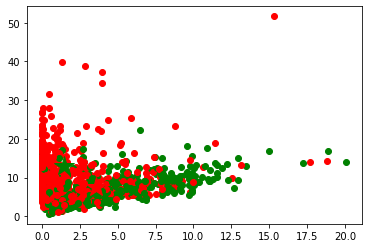

In [649]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans,AffinityPropagation, SpectralClustering

# 读取数据
data = np.array(Gini_act)
# 聚类数量
k = 2
# 训练模型

# model = AffinityPropagation(damping=0.5, max_iter=500, convergence_iter=30,
#                          preference=-50).fit(data)
# centers = model.cluster_centers_
# result = model.labels_

# model = SpectralClustering(gamma=0.1, n_clusters=2)
# model.fit_predict(data)
# # centers = model.cluster_centers_
# result = model.labels_


model = KMeans(n_clusters=k)
model.fit(data)
# 分类中心点坐标
centers = model.cluster_centers_
# 预测结果
result = model.predict(data)


# 用不同的颜色绘制数据点
mark = ['or', 'og']
for i, d in enumerate(data):
    plt.plot(d[0], d[1], mark[ground_truth_cluster[i]])
# 画出各个分类的中心点
mark = ['*r', '*g']
for i, center in enumerate(centers):
    plt.plot(center[0], center[1], mark[i], markersize=20)

# # 绘制簇的作用域
# # 获取数据值所在的范围
# x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
# y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1

# # 生成网格矩阵
# xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
# z = model.predict(np.c_[xx.ravel(), yy.ravel()])
# z = z.reshape(xx.shape)
# cs = plt.contourf(xx, yy, z)
# plt.show()

In [475]:
# centers = model.cluster_centers_
result = model.labels_

In [ ]:
SpectralClustering().fit_predict

In [ ]:
SpectralClustering().fit

In [428]:
print(1-result)

[0 1 0 0 1 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 1 0 0 1 1 0
 0 0 0 1 0 1 1 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 1 1
 1 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0
 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0
 1 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 1
 0 0 1 0 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0]


In [591]:
ground_truth_cluster = np.zeros([len(result)], dtype=np.int32)
ground_truth_cluster[wrong_index]=1
print(ground_truth_cluster)

[1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 1 0 1 0 0 1 1 0 0 1
 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0
 1 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0
 0 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 0
 0 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 0
 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1
 1 0 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0
 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0
 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0
 0 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 

In [694]:
# print(np.sum(ground_truth_cluster&clf.predict(data)))
# print(np.sum(ground_truth_cluster & (1-result)), np.sum(ground_truth_cluster), np.sum(1-result))

clf.predict_proba(data[0].reshape(-1, 16))[0][1]
# SVM_Gini_act

0.6524837034965916

In [688]:
svm.SVC?

In [710]:
from sklearn import datasets
from sklearn import model_selection
from sklearn import svm
# 加载数据集
cancer = datasets.load_breast_cancer()
X = data  # 样本
y = ground_truth_cluster  # 类别
# 划分数据集
X_trainer, X_test, Y_trainer, Y_test = model_selection.train_test_split(data, ground_truth_cluster, test_size=0.3)
# 分类器
# kernel : {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'}, default='rbf'
clf = svm.SVC(kernel="rbf", probability=True)   # 参数kernel为线性核函数
clf.fit(X_trainer, Y_trainer)  # 训练分类器
print("Support Vector：\n", clf.n_support_)  # 每一类中属于支持向量的点数目
# print("Predict：\n", clf.predict(X_test))  # 对测试集的预测结果
score = clf.score(X_test, Y_test)  # 模型得分
print("Score：", score)


Support Vector：
 [201 196]
Score： 0.7833333333333333


In [711]:
SVM_Gini_act = []
for data1 in data:
    SVM_Gini_act.append(  clf.predict_proba(data1.reshape(-1, 16))[0][1]  )

indexs = np.argsort(SVM_Gini_act)
indexs = indexs[::-1]
# print(indexs)
APFD,wrong_number,wrong_index = get_APFD(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), 
                predicted_confidence=np.array(predicted_confidence), top_set=top_set)
print("APFD: ", APFD, wrong_number)
RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), 
                predicted_confidence=np.array(predicted_confidence), top_set=top_set)
print("RAUC: ", RAUC)


100% |########################################################################|


APFD:  0.7262464387464387 351
RAUC:  0.8796926530259863


293

In [664]:
clf?

In [253]:
import keras
def get_loss_gradients(img_input, model, target_one_hot, from_logits=False):
    images = tf.cast(img_input, tf.float32)
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=from_logits)
    with tf.GradientTape() as tape:
        tape.watch(images)
        preds = model(images)
        loss = cce(target_one_hot, preds)
#         top_class = preds[:, top_pred_idx]

    grads = tape.gradient(loss, images)
    return grads

# def get_loss_gradients_Layer(img_input, hidden_layer_input, model, target_one_hot, layer_name = None):
#     images = tf.cast(img_input, tf.float32)
#     hidden_layer_input = tf.cast(hidden_layer, tf.float32)
#     cce = tf.keras.losses.CategoricalCrossentropy()
#     if layer_name is not None:
# #         model_layer = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
#         with tf.GradientTape() as tape:
#             tape.watch(hidden_layer_input)
#             preds = model(images)
#             loss = cce(target_one_hot, preds)
#     #         top_class = preds[:, top_pred_idx]
#     else:
#         with tf.GradientTape() as tape:
#             tape.watch(images)
#             preds = model(images)
#             loss = cce(target_one_hot, preds)
#     grads = tape.gradient(loss, images)
#     return grads

# def get_loss_gradients_Layer(img_input, hidden_layer_input, model, target_one_hot, layer_name = None):
#     images = tf.cast(img_input, tf.float32)
#     cce = tf.keras.losses.CategoricalCrossentropy()
#     if layer_name is not None:
#         model_layer = Model(inputs=hidden_layer_input, outputs=model.get_layer('fc2').output)
#         hidden_layer = tf.cast(hidden_layer_input, tf.float32)
#         with tf.GradientTape() as tape:
#             tape.watch(hidden_layer)
#             preds = model_layer(hidden_layer)
#             print(np.shape(preds), np.sum(preds))
#             loss = cce(target_one_hot, preds)
#     #         top_class = preds[:, top_pred_idx]
#     else:
#         with tf.GradientTape() as tape:
#             tape.watch(images)
#             preds = model(images)
#             loss = cce(target_one_hot, preds)
#     grads = tape.gradient(loss, images)
#     return grads


In [24]:
# 对中间隐层特征进行分级，计算基尼指数/信息熵
from tensorflow.keras import backend as BE

num_class = 100
# img_num = range(0,10)
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)
Gini_act=[]
# ground_truth_label = []
# predicted_confidence = []
pbar = ProgressBar()
for i in pbar(img_num):
    img_path = DATA_PATH + file_name[i]
    img = image.load_img(img_path, target_size=(224, 224))
    x_tmp = image.img_to_array(img)
    x_tmp = np.expand_dims(x_tmp, axis=0)
    x_tmp = preprocess_input(x_tmp)
    
    #  使用分组机制
#     x_act = softmax(model.predict(np.reshape(x_tmp, [-1,224,224,3])))
    x_act = model.predict(np.reshape(x_tmp, [-1,224,224,3]))
    mu = np.average(x_act[0])
    sigma = np.std(x_act[0])
    x_act[0] = (x_act[0] - mu) / sigma
    
    # attention机制
    att1 = np.dot(np.transpose(x_act), x_act)
    att_weight = np.mean(att1, axis = 0).reshape(np.shape(x_act))
    x_act = x_act*att_weight

    x_act_sorted = np.sort(x_act[0])[::-1]  # 对x_act进行从大到小排序
    group1 = int(np.shape(x_act)[1]/num_class)
    if group1<1:
        break
    vect1 = np.zeros((1, num_class))
    x_act_sorted = np.sort(x_act[0])[::-1]
    for j in range(0, num_class-1):
        vect1[0][j] = np.sum(x_act_sorted[j*group1:(j+1)*group1])
    vect1[0][-1] = np.sum(x_act_sorted[num_class*group1:-1])

    Gini_tmp = 1-np.sum(vect1*vect1)  # 基于基尼指数
#     Gini_tmp = -np.sum(x_act*np.log(x_act))  # 基于信息熵
    Gini_act.append(Gini_tmp)

100% |########################################################################|


In [26]:
img_num

range(0, 100)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


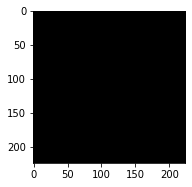

In [25]:
import matplotlib.pyplot as plt

plt.figure()
plt.subplot(121)
plt.imshow(grads[0])
# plt.subplot(122)
# plt.imshow(igrads)

In [358]:
# indexs = np.argsort(Gini_act)
# indexs = indexs[::-1]
# APFD,_,_ = get_APFD(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), 
#                 predicted_confidence=np.array(predicted_confidence), top_set=top_set)
# print("APFD: ", APFD)
# # o_i = 0
# # pbar = ProgressBar()
# # for i in pbar(range(0, index1)):
# # # for i in range(0, index1):
# #     img_path = DATA_PATH + file_name[indexs[i]]
# #     img = image.load_img(img_path, target_size=(224, 224))
# #     x_tmp = image.img_to_array(img)
# #     x_tmp = np.expand_dims(x_tmp, axis=0)
# #     x_tmp = preprocess_input(x_tmp)
# #     pre_tmp = base_model.predict(np.reshape(x_tmp, [-1,224,224,3]))
# #     if not get_acc(predict_label=decode_predictions(pre_tmp, top=top_set), ground_truth=WNID[val_ground_truth[indexs[i]]-1]):
# #         o_i = o_i+i
# # #         print(i,o_i)
# # APFD = 1-o_i/(index1*(index1-index2))+1/(2*index1)
# # print("APFD: ", APFD)

APFD:  0.48671428571428577


In [39]:
# # 前200个样本
# APFD:  0.9518749999999999 # 未使用attention机制，fc2层特征，基于基尼指数
# APFD:  0.9358593749999999    # 未使用attention机制，fc2层特征，基于信息熵
# APFD:  0.943359375   # 使用attention机制，fc2层特征，基于基尼指数
# APFD:  0.9811718749999999 # 使用attention机制，fc2层特征，基于信息熵
# # 前10000个样本
# APFD:  0.961101140629512    # 使用attention机制，fc2层特征，基于信息熵

300

In [360]:
# # 计算RAUC指标
# RAUC,_,_ = get_RAUC(Gini_indexs=indexs, ground_truth_label=np.array(ground_truth_label), 
#                 predicted_confidence=np.array(predicted_confidence), top_set=top_set)
# print("RAUC: ", RAUC)

# # true_y_axis = []
# # pre_y_axis = []
# # o_i = 0
# # pbar = ProgressBar()
# # for i in pbar(range(0, index1)):
# #     img_path = DATA_PATH + file_name[indexs[i]]
# #     img = image.load_img(img_path, target_size=(224, 224))
# #     x_tmp = image.img_to_array(img)
# #     x_tmp = np.expand_dims(x_tmp, axis=0)
# #     x_tmp = preprocess_input(x_tmp)
# #     pre_tmp = base_model.predict(np.reshape(x_tmp, [-1,224,224,3]))
# #     if not get_acc(predict_label=decode_predictions(pre_tmp, top=top_set), ground_truth=WNID[val_ground_truth[indexs[i]]-1]):
# #         o_i = o_i+1
# #         pre_y_axis.append(o_i)
# #     else:
# #         pre_y_axis.append(o_i)
# #     if i < index1-index2:
# #         true_y_axis.append(i+1)
# #     else:
# #         true_y_axis.append(index1-index2)
            
# # RAUC = np.sum(pre_y_axis)/np.sum(true_y_axis)
# # print("RAUC: ", RAUC)

RAUC:  0.5803786574870913


In [107]:
WNID[val_ground_truth[indexs[i]]-1]

'n01751748'

In [108]:
decode_predictions?

394


'n02640242'

In [ ]:
n02640242